# Introduction to gimVI
## Impute missing genes in Spatial Data from Sequencing Data

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../")

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/dataset_refactor/tests/notebooks/gimvi_tutorial.ipynb)

In [23]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the gimvi notebook")

show_plot = True
test_mode = False
save_path = "data/"

def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

if not test_mode:
    save_path = "../../data"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dataset_refactor#egg=scvi[notebooks]

In [26]:
import scanpy
import anndata

from scvi.dataset import (
    prefrontalcortex_starmap,
    frontalcortex_dropseq,
    smfish,
    cortex,
    setup_anndata
)
from scvi.models import JVAE, Classifier
from scvi.inference import JVAETrainer

import numpy as np
import copy
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

if IN_COLAB or not test_mode:
    %matplotlib inline

In [4]:
def plot_umap(trainer):
    latent_seq, latent_fish = trainer.get_latent()
    latent2d = umap.UMAP().fit_transform(np.concatenate([latent_seq, latent_fish]))
    latent2d_seq = latent2d[: latent_seq.shape[0]]
    latent2d_fish = latent2d[latent_seq.shape[0] :]

    data_seq, data_fish = [p.gene_dataset for p in trainer.all_dataset]

    colors = sns.color_palette(n_colors=30)
    plt.figure(figsize=(25, 10))
    ax = plt.subplot(1, 3, 1)
    ax.scatter(*latent2d_seq.T, color="r", label="seq", alpha=0.5, s=0.5)
    ax.scatter(*latent2d_fish.T, color="b", label="osm", alpha=0.5, s=0.5)
    ax.legend()

    ax = plt.subplot(1, 3, 2)
    labels = data_seq.labels.ravel()
    for i, label in enumerate(data_seq.cell_types):
        ax.scatter(
            *latent2d_seq[labels == i].T,
            color=colors[i],
            label=label[:12],
            alpha=0.5,
            s=5
        )
    ax.legend()
    ax.set_title("Seq cells")

    ax = plt.subplot(1, 3, 3)
    labels = data_fish.labels.ravel()
    for i, label in enumerate(data_fish.cell_types):
        ax.scatter(
            *latent2d_fish[labels == i].T, color=colors[i], label=label, alpha=0.5, s=5
        )
    ax.legend()
    ax.set_title("Spatial cells")


def imputation_score(trainer_both, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = trainer_both.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original /= data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))


def plot_gene_spatial(trainer, data_spatial, gene):
    data_seq, _ = [p.gene_dataset for p in trainer.all_dataset]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x_coord"]
    y_coord = data_fish.obs["y_coord"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = trainer.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


## Load two datasets: one with spatial data, one from sequencing

Here we load: 
- **Cortex**: a scRNA-seq dataset of 3,005 mouse somatosensory cortex cells (Zeisel et al., 2015)
- **osmFISH**: a smFISH dataset of 4,462 cells and 33 genes from the same tissue (Codeluppi et al., 2018)

In [8]:
data_spatial = smfish(save_path=save_path, use_high_level_cluster = True, run_setup_anndata=False)
data_spatial.obs['batch'] = np.zeros(data_spatial.shape[0])

data_seq_labels_key = "labels"
data_spatial_labels_key = "labels"

data_seq_cell_type_key = 'cell_type'
data_spatial_cell_type_key = 'str_labels'

data_seq = cortex(save_path=save_path, run_setup_anndata=False)

if test_mode:
    data_seq = data_spatial.copy()
    data_seq_labels_key = data_spatial_labels_key
    data_seq_cell_type_key = data_spatial_cell_type_key

[2020-07-22 02:43:35,179] INFO - scvi.dataset._built_in_data._utils | File /data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
[2020-07-22 02:43:35,185] INFO - scvi.dataset._built_in_data._smfish | Loading smFISH dataset
[2020-07-22 02:43:35,305] INFO - scvi.dataset._built_in_data._utils | File /data/expression.bin already downloaded
[2020-07-22 02:43:35,312] INFO - scvi.dataset._built_in_data._cortex | Loading Cortex data from /data/expression.bin
[2020-07-22 02:43:46,137] INFO - scvi.dataset._built_in_data._cortex | Finished loading Cortex data


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


- **FrontalCortexDropseq**: a scRNA-seq dataset of 71,639 mouse frontal cortex cells (Saunders et al., 2018)
- **PreFrontalCortexStarmap**: a starMAP dataset of 3,704 cells and 166 genes from the mouse pre-frontal cortex (Wang et al., 2018)


In [9]:
# data_spatial = prefrontalcortex_starmap(save_path=save_path, run_setup_anndata = False)
# data_seq = frontalcortex_dropseq(save_path=save_path, run_setup_anndata = False)

# data_seq_labels_key = 'Clusters'
# data_spatial_labels_key = 'labels'

# data_seq_cell_type_key = 'CellTypes'
# data_seq.obs[data_seq_cell_type_key] = [data_seq.uns['CellTypes'][i] for i in data_seq.obs['Clusters']]
# data_spatial_cell_type_key = 'labels'

# scanpy.pp.subsample(data_seq, n_obs = 5000)

**Hide some genes in the osFISH dataset to score the imputation**

In [10]:
data_seq = data_seq[:, data_spatial.var_names].copy()
scanpy.pp.filter_cells(data_spatial, min_counts= 1)
scanpy.pp.filter_cells(data_seq, min_counts = 1)

In [11]:
train_size = 0.8

gene_names_rnaseq = data_seq.var_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = data_spatial.copy()
data_spatial_partial = data_spatial_partial[:, gene_names_fish].copy()

setup_anndata(data_seq, labels_key=data_seq_labels_key)
setup_anndata(data_spatial_partial,batch_key = 'batch', labels_key= data_spatial_labels_key )

data_spatial_partial.obs['_scvi_batch'] += data_seq.uns['scvi_summary_stats']['n_batch']

[2020-07-22 02:43:46,601] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-22 02:43:46,602] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-07-22 02:43:46,607] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-22 02:43:46,608] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-22 02:43:46,617] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 2996 cells, 33 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-07-22 02:43:46,622] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-07-22 02:43:46,623] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-07-22 02:43:46,628] INFO - scvi.dataset._anndata | Using labels from adata.obs["labels"]
[2020-07-22 02:43:46,629] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-07-22 02:43:46,64

**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [12]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.uns['scvi_summary_stats']['n_genes'] for d in datasets]
total_genes = data_seq.uns['scvi_summary_stats']['n_genes']
n_batches = sum([d.uns['scvi_summary_stats']['n_batch'] for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 1

In [13]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [14]:
n_epochs = if_not_test_else(200, 1)
trainer.train(n_epochs=n_epochs)

training: 100%|██████████| 200/200 [04:24<00:00,  1.32s/it]


In [15]:
latent_seq, latent_spatial = trainer.get_latent()

latent_representation = np.concatenate([latent_seq, latent_spatial])

latent_adata = anndata.AnnData(latent_representation)
latent_labels = (['seq'] * latent_seq.shape[0]) + (['spatial'] * latent_spatial.shape[0])
latent_adata.obs['labels'] = latent_labels

In [31]:
scanpy.pp.neighbors(latent_adata)
scanpy.tl.umap(latent_adata)

In [32]:
data_seq.obsm['X_umap'] = latent_adata.obsm['X_umap'][:data_seq.shape[0]]
data_spatial.obsm['X_umap'] = latent_adata.obsm['X_umap'][data_seq.shape[0]:]

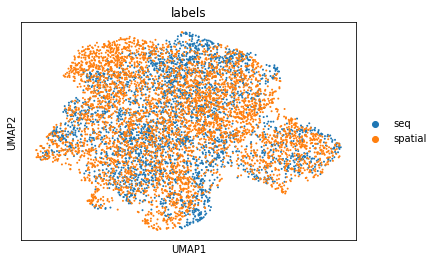

In [33]:
scanpy.pl.umap(latent_adata, color = 'labels', show = show_plot)

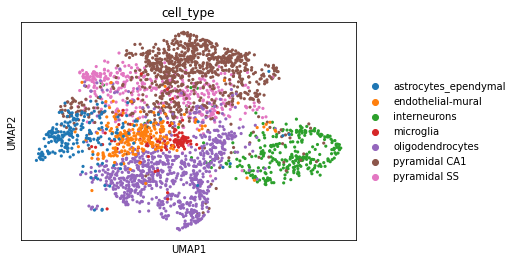

In [34]:
scanpy.pl.umap(data_seq, color = data_seq_cell_type_key, show = show_plot)


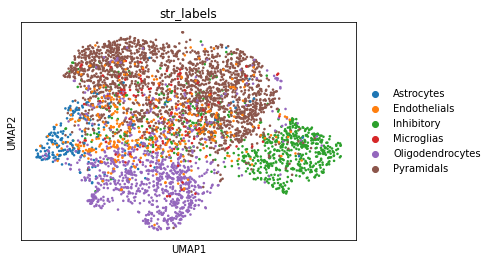

In [35]:
scanpy.pl.umap(data_spatial, color = data_spatial_cell_type_key, show = show_plot)


In [36]:
imputation_score(trainer, data_spatial, gene_ids_test, True)

0.25110878342492604

### Plot imputation for *LAMP5*, hidden in the training

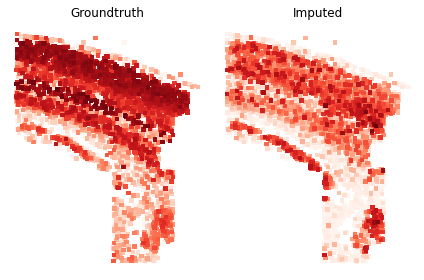

In [38]:
plot_gene_spatial(trainer, data_spatial, 9)

### Inspect classification accuracy (we expect a uniform matrix)
If the matrix is diagonal, the `kappa` needs to be scaled up to ensure mixing.

In [39]:
discriminator_classification = trainer.get_discriminator_confusion()
discriminator_classification

array([[0.49529922, 0.50470084],
       [0.48451406, 0.51548576]], dtype=float32)

In [40]:
import pandas as pd

results = pd.DataFrame(
    trainer.get_loss_magnitude(),
    index=["reconstruction", "kl_divergence", "discriminator"],
    columns=["Sequencing", "Spatial"],
)
results.columns.name = "Dataset"
results.index.name = "Loss"
results

Dataset,Sequencing,Spatial
Loss,,
reconstruction,861.732307,1760.409245
kl_divergence,195.616313,206.328495
discriminator,24.243926,22.646365
